In [1]:
import os
import json
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
import subprocess

In [2]:
def read_pages(folder):
    
    #folder = "./test"
    data = {}

    for cname in os.listdir(folder):
        data[cname] = {}
        print(cname)
        for chkpt in os.listdir(folder + "/" + cname):
            data[cname][chkpt] = {}

            for file in os.listdir(folder + "/" + cname + "/" + chkpt):
                fname = folder + "/" + cname + "/" + chkpt + "/" + file
                #print(fname)

                if 'img' in fname and 'tar' not in fname:
                    bytes = Path(fname).read_bytes()

                    print(f"{fname}: {len(bytes)}")
                    data[cname][chkpt][file[:-4]] = bytes

    return data



In [3]:
folder = "../../checkpointing/scripts/post_chkpts"
data = read_pages(folder)

socialnetwork_home-timeline-service_1
../../checkpointing/scripts/post_chkpts/socialnetwork_home-timeline-service_1/socialnetwork_home-timeline-service_1_2023-03-16T072921/pages-1.img: 659456
../../checkpointing/scripts/post_chkpts/socialnetwork_home-timeline-service_1/socialnetwork_home-timeline-service_1_2023-03-16T072711/pages-1.img: 659456
../../checkpointing/scripts/post_chkpts/socialnetwork_home-timeline-service_1/socialnetwork_home-timeline-service_1_2023-03-16T073843/pages-1.img: 659456
../../checkpointing/scripts/post_chkpts/socialnetwork_home-timeline-service_1/socialnetwork_home-timeline-service_1_2023-03-16T071949/pages-1.img: 659456
../../checkpointing/scripts/post_chkpts/socialnetwork_home-timeline-service_1/socialnetwork_home-timeline-service_1_2023-03-16T072359/pages-1.img: 659456
../../checkpointing/scripts/post_chkpts/socialnetwork_home-timeline-service_1/socialnetwork_home-timeline-service_1_2023-03-16T072154/pages-1.img: 659456
../../checkpointing/scripts/post_chkpt

In [4]:
def plot_state(container_name, data, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,6))
    checkpoints = data[container_name]
    state_size = []
    for k in checkpoints:
        #print(k)
        timestamp = k.split('_')[-1]
        dt = datetime.strptime(timestamp, '%Y-%m-%dT%H%M%S')
        state_size.append({'timestamp':dt, 'size': len(checkpoints[k]['pages-1'])/1024})
    df = pd.DataFrame(state_size)
    
    df.set_index('timestamp').plot(style='-o', ax =ax)
    ax.set_xlabel('Timestamp', fontsize=20)
    ax.set_ylabel('Size(KB)', fontsize=20)
    ax.tick_params(axis='x', which='major', labelsize=20, rotation=90)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))   #to get a tick every 15 minutes
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))     #optional formatting 
    #
    return ax

dict_keys(['pages-'])

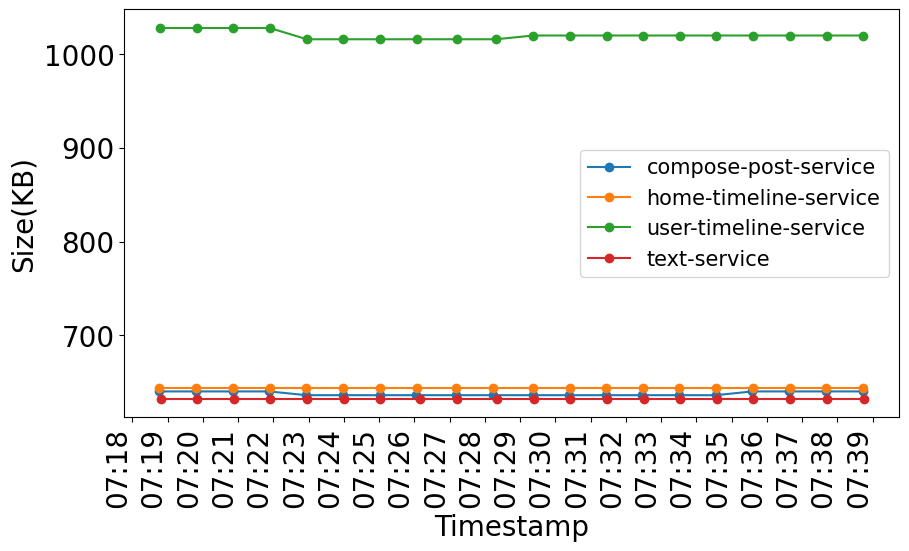

In [5]:
ax = plot_state('socialnetwork_compose-post-service_1', data)
ax = plot_state('socialnetwork_home-timeline-service_1', data, ax)
ax = plot_state('socialnetwork_user-timeline-service_1', data, ax)
ax = plot_state('socialnetwork_text-service_1', data, ax)
ax.legend(['compose-post-service', 'home-timeline-service',\
          'user-timeline-service', 'text-service'], fontsize=15, )

In [18]:
def plot_state_change(container_name, data, dirname, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,6))
    checkpoints = data[container_name]
    state_change_size = []
    chkpts = []
    for k in checkpoints:
        #print(k)
        timestamp = k.split('_')[-1]
        dt = datetime.strptime(timestamp, '%Y-%m-%dT%H%M%S')
        #chkpt = checkpoints[k]['pages-1']
        #print(container_name, k)
        fname1 = container_name + '/' + k + '/' + 'pages-1.img'
        chkpts.append({'timestamp': dt, 'file': fname1})
    for i in  range(1, len(chkpts)):
        
        fname1 = dirname + '/' + chkpts[i-1]['file']
        fname2 = dirname + '/' + chkpts[i]['file']
        #print(fname1, fname2)
        result = subprocess.run('cmp ' + fname1 + ' ' + fname2 + ' -l', capture_output=True, shell=True, text=True)
        diff = str(result.stdout)
        state_change_size.append({'timestamp': chkpts[i]['timestamp'], 'change(KB)': len(diff.split('\n'))/1000})
        
        #print(len(diff.split('\n')))
    df = pd.DataFrame(state_change_size)    
    #print(df)
    df.set_index('timestamp').plot(style='-o', ax =ax)
    ax.set_xlabel('Timestamp', fontsize=20)
    ax.set_ylabel('Size Change(KB)', fontsize=20)
    ax.tick_params(axis='x', which='major', labelsize=20, rotation=90)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))   #to get a tick every 15 minutes
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))     #optional formatting 
    #
    return ax

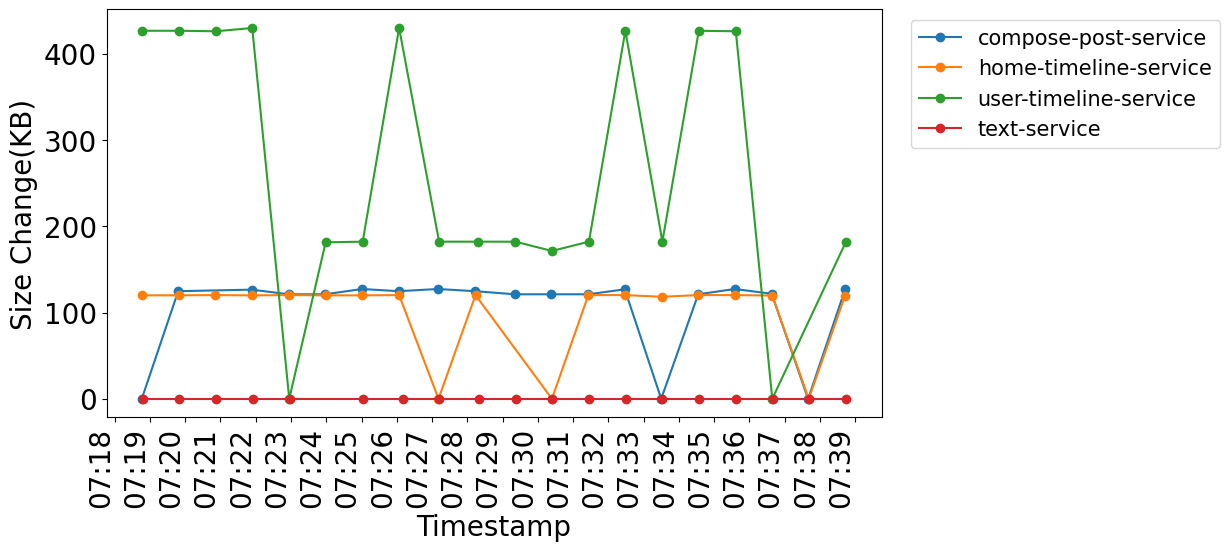

In [29]:
ax = plot_state_change('socialnetwork_compose-post-service_1', data, folder)
ax = plot_state_change('socialnetwork_home-timeline-service_1', data, folder, ax)
ax = plot_state_change('socialnetwork_user-timeline-service_1', data, folder, ax)
ax = plot_state_change('socialnetwork_text-service_1', data, folder, ax)
ax.legend(['compose-post-service', 'home-timeline-service',\
          'user-timeline-service', 'text-service'], fontsize=15, loc='upper right', bbox_to_anchor=(1.45, 1))